Lista #3 MCMC
===

Thiago da Mota Souza - thiagosz@cos.ufrj.br

## Imports

In [1]:
import math
import numpy as np
import random
import time
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import requests
import scipy.special
from multiprocessing import Pool
from tqdm import tqdm 

## Questão 1

Usando a mesma ideia da utilizada em sala de aula, podemos considerar o sorteio de pontos dentro de um quadrado de lado unitário que estão contidos em um triângulo $ABC$ de lados $\overline{AB}=1$, $\overline{AC}=1$ e $\angle{BAC} = \alpha = \pi/4$. A área desse triângulo é:

$$
\begin{equation}
Area(ABC) = \frac{\sin{(\alpha)}x1x1}{2} = \frac{\sqrt{2}}{4}
\end{equation}
$$

### Questão 1.1

Estabelecendo o vértice A como a origem do sistema de coordenadas, o eixo $x$ congruente ao lado $AC$ e o eixo $y$ perpendicular ao eixo $x$ como o de costume. Assim temos: $A = (0,0)$, $B=\sqrt{2}/2(1,1)$ e $C=(1,0)$

Podemos definir as funções determinísticas, $f_{AB}$ e $f_{BC}$, que descrevem os lados $AB$ e $BC$ respectivamente nos nos intervalos $x \in [0,1/2]$ e $x \in [1/2,1]$

$$
\begin{equation}
f_{AB} = \sqrt{2}x
\end{equation}
$$

$$
\begin{equation}
f_{BC} = -\sqrt{2}x + \sqrt{2}
\end{equation}
$$

E portanto vamos definir a função $g$ que descreve da sequinte forma

$$
g(x) = 
     \begin{cases}
       \sqrt{2}x & 0 \geq x < 1/2 \\
       -\sqrt{2}x + \sqrt{2}, & 1/2 < x \leq 1 \\
     \end{cases}
$$

> OBS: eu entendo que devido as constantes da função g, o que segue tem uma falha que é eu ter que usar o valor de $\sqrt{2}$ no computo de g. Não tenho tempo para bolar uma outra forma geométrica que escape à isso e vou seguir a questão ignorando esse fato que não altera o uso de Monte Carlo em si.

Utilizando a mesma ideia da usada para achar $\pi$ em sala de aula, podemos estimar a área em baixo dda função $g$ no intervalo $[0,1]$ Para isso devemos definir: $X,Y \sim Uniforme(0,1)$. Por tanto:

$$
\begin{equation}
\label{eq:Q-1-area-int}
Area(ABC) = \int_{x=0}^{1}g(x)dx = E[g(X)] = \frac{\sqrt(2)}{4}
\end{equation}
$$


### Questão 1.2

da questão anterior, temos que:

$$
\begin{equation}
\sigma_{g(X)}^2 = E[(g(X)- \mu_{g(x)})^2] = E[g(X)^2] - \mu_{g(X)}^2
\end{equation}
$$

A média, $\mu_{g(X)}$ foi construida a partir da área do triângulo e portanto já sabemos que seu valor é $\sqrt{2}{4}$, mas isso pode ser verificado por:

$$
\begin{multline}
\mu_{g(X)} = E[g(X)] = \int_{0}^{1/2}\sqrt{2}xdx + \int_{1/2}^{1}(-\sqrt{2}x + \sqrt{2})dx = \\
\frac{\sqrt{2}}{2}x^2\bigg\rvert_{0}^{1/2} + \sqrt(2)\left(-1/2x^2 + x\right)\bigg\rvert_{1/2}^{1} = \frac{\sqrt{2}}{8} \frac{\sqrt{2}}{8} = \frac{\sqrt{2}}{4}
\end{multline}
$$

Para o cálculo de $\sigma_{g(X)}^2$, temos:

$$
\begin{multline}
E[g(X)^2] = \int_{0}^{1/2}2x^2dx + \int_{1/2}^{1}(x^2 -4x + 2)dx = \\
\frac{2}{3}x^3\bigg\rvert_{0}^{1/2} + (1/3x^3 -2x^2 + 2x)\bigg\rvert_{1/2}^{1} = \frac{2}{24} + \frac{19}{24} = \frac{7}{8}
\end{multline}
$$

logo:
$$
\begin{equation}
\sigma_{g(X)}^2 = E[(g(X)- \mu_{g(x)})^2] = E[g(X)^2] - \mu_{g(X)}^2 = \frac{7}{8} - \frac{1}{8} = \frac{3}{4}
\end{equation}
$$


### Questão 1.3

da documentação da biblioteca [numpy](https://numpy.org/doc/stable/reference/random/bit_generators/mt19937.html) do python, temos que a função ```numpy.random.MT19937``` usa o algoritmo de Mersenne Twister.

In [2]:
def generate_sample(g_fun, sample_sz, a=0,b=1):
    """Gerador genérico de amostras da função g aplicada sobre uma distribuição uniforme X no intervalo [a,b]"""
    vectorized_g_fun = np.vectorize(g_fun)
    
    x_list = np.random.uniform(a,b,sample_sz)
    
    return vectorized_g_fun(x_list), x_list

In [3]:
def g_fun(x):
    if x < 0.5:
        return math.sqrt(2)*x
    return math.sqrt(2)*(-x+1)

### Questão 1.4

fazendo a correção para a definção de erro do meu estimador, uma vez que a V.A. que eu estou gerando não tem expectativa $\sqrt(2)$, mas sim $\sqrt(2)/4$ 

$$
\begin{equation}
\hat{e}_{n} = \frac{|M_n - \sqrt{2}/4|}{\sqrt{2}/4}
\end{equation}
$$

Essa é a função de erro MAE (Mean absolute error)

> Como sabemos que a média amostral tem uma variância, vou utilizar K-folds para visualizar a variância do estimador

In [4]:
def mae(y_true, y_pred):
    return abs(y_true - y_pred)/y_true
mae = np.vectorize(mae)

In [5]:
def sanple_mean_estimator(values):
    return np.mean(values)

In [6]:
def run_mc_estimator(sample_gen, sample_size, mae, estimator, true_val, num_folds=5):
    
    sample_sz_compansate_folds = math.ceil((num_folds+1)*sample_size/num_folds)
    samples,_ = sample_gen(sample_sz_compansate_folds)
    
    num_folds = min(sample_sz_compansate_folds, num_folds)
    
    kf = KFold(n_splits=num_folds, shuffle=False)
    estimate_sample = []
    error_sample = []
    for fold,_ in kf.split(samples):
        data = samples[fold]
        estimate = estimator(data)
        estimate_sample.append(estimate)
        if true_val:
            error = mae(true_val, estimate)
            error_sample.append(error)
        
    return estimate_sample, error_sample

In [7]:
def g_sample_generator(sample_sz):
    global g_fun
    return generate_sample(g_fun, sample_sz, 0,1)

def run_experiments(min_sample_sz, max_sample_sz):
    global g_sample_generator, run_mc_estimator, mae, sanple_mean_estimator
    
    true_val = math.sqrt(2)/4
    range_len = max_sample_sz - min_sample_sz + 1
    estimates = np.zeros([5, range_len])
    errors = np.zeros([5, range_len])
    
    for i,sample_sz in enumerate(tqdm(range(min_sample_sz, max_sample_sz + 1))):
        estimates_for_n, error_samples_for_n = run_mc_estimator(g_sample_generator, sample_sz, mae, sanple_mean_estimator, true_val)
        estimates[:,i] = estimates_for_n
        errors[:,i] = error_samples_for_n
    return estimates, errors

In [8]:
%%time
max_sample_size = int(1e4)
estimates, errors = run_experiments(5,max_sample_size)

100%|██████████| 9996/9996 [00:18<00:00, 546.47it/s] 

CPU times: user 18.3 s, sys: 52.5 ms, total: 18.3 s
Wall time: 18.3 s


In [9]:
def plot_experiment1(estimates, error):

    true_val = true_val = math.sqrt(2)/4
    
    fig = plt.figure(figsize=(10, 8))
    plt.title('estimativa usando MC')
    plt.subplot(2,1,1)
    plt.plot(estimates.T, 'x', color='blue');
    plt.axhline(y=true_val, color='r', linestyle='-')
    plt.grid(True)
    plt.xlabel('tamanho da amostra')
    plt.ylabel('estimativa')
    
    plt.subplot(2,1,2)
    plt.plot(error.T, 'x', color='blue');
    plt.axhline(y=0, color='r', linestyle='-')
    plt.grid(True)
    plt.xlabel('tamanho da amostra')
    plt.ylabel('mae')
    
    fig.subplots_adjust(top=0.85)
    plt.show()

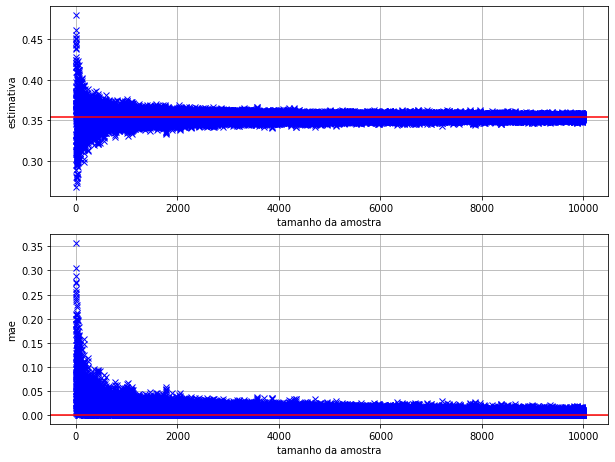

In [10]:
plot_experiment1(estimates, errors)

## Questão 2

### Questão 2.1

$$
\begin{equation}
f_X(x) = \lambda e^{-\lambda x} \implies F_X(x) = -e^{-\lambda x}
\end{equation}
$$

Logo

$$
\begin{equation}
F_X^{-}1(x) = \frac{1}{-\lambda}ln(x)
\end{equation}
$$

In [35]:
def direct_q2_1(x,lam):
    return lam*math.exp(-lam*x)
def inversa_q2_1(x, lam):
    return -(math.log(x)/lam)

Usando o método da inversa podemos criar o seguinte função geradora de amostrar para a distribuição

In [36]:
def sample_generator_q_21(sample_sz, lam):
        
    def param_inv(x):
        global inversa_q2_1
        return inversa_q2_1(x, lam)
    
    sample, x = generate_sample(param_inv, sample_sz, 0,1)
    return sample, x

In [73]:
len_sample = 1000
par_q21 = 4
sample_q21, x = np.array(sample_generator_q_21(len_sample, par_q21))
ran = np.linspace(np.min(sample_q21),np.max(sample_q21),num=len_sample)
distribution_q21 = [direct_q2_1(a, par_q21) for a in ran]

In [76]:
def plot_hist(sample, expected, ran):
    fig = plt.figure()
    ax = plt.hist(sample,density=True)
    plt.plot(ran, expected, '-r')
    plt.title("histograma da ddistribuição")
    plt.xlabel("X")
    plt.ylabel("freq")
    plt.grid(True)
    plt.show()

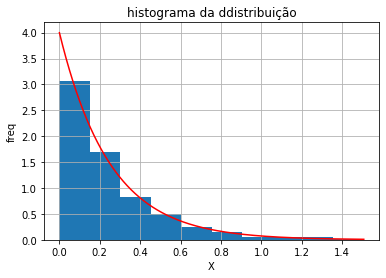

In [77]:
plot_hist(sample_q21,distribution_q21,ran)

### Questão 2.2

$$
\begin{equation}
f_X(x) = \begin{cases}
\frac{\alpha x_0^\alpha}{x^{\alpha+1}} & x > x_0 \\
0 & \text{caso contrário}
\end{cases} 
\implies F_X(x) = \begin{cases}
1 - \left(\frac{x_0^\alpha}{x}\right)^\alpha & x > x_0 \\
0 & \text{caso contrário}
\end{cases}
\end{equation} 
$$

logo

$$
\begin{equation}
F_X^{-1}(x) =
\frac{x_0}{(x-1)^{1/\alpha}}, x \in [0,1]
\end{equation}
$$

No intervalo $[0,x_0)$ a função não é de fato inversível, mas isso não importa uma vez que a distribuição de massa neste invervalo é 0.

In [118]:
def direct_q2_2(x, alpha, x0):
    if x < x0:
        return 0
    return alpha*(x0**alpha)/(x**(alpha+1))
def inversa_q2_2(x, alpha, x0):
    return x0/((1-x)**(1/alpha))

In [129]:
def sample_generator_q_22(sample_sz, alpha, x0):
    global inversa_q2_2
    
    def param_inv(x):
        return inversa_q2_2(x, alpha, x0)
    
    sample, x = generate_sample(param_inv, sample_sz)
    return sample, x

In [131]:
len_sample = 1000
par_q22_1 = 4
par_q22_2 = 2
sample_q22, x = np.array(sample_generator_q_22(len_sample, par_q22_1, par_q22_2))
ran2 = np.linspace(np.min(sample_q22),np.max(sample_q22),num=len_sample)
distribution_q22 = [direct_q2_2(a, par_q22_1,par_q22_2) for a in ran]

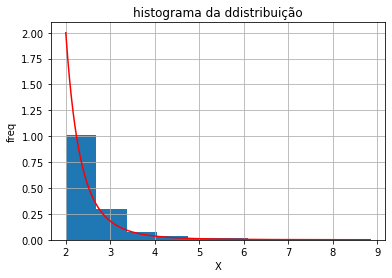

In [132]:
plot_hist(sample_q22,distribution_q22,ran2)

## Questão 3

Sendo I uma V.A indicadora que atribuí 1 caso se escolha um domínio existe do conjunto, D, de todos os possíveis domínios de tamanho k e 0 caso contrário. Sendo N o número de domínios existentes, podemos escrever que:

$$
\begin{equation}
I_i \sim Indicadora(p=\frac{1}{N}), i \in D
\end{equation}
$$

Definindo $X \sim Uniforme(1,|D|)$

$$
\begin{equation}
E[I(X)] = \frac{N}{|D|} \implies N = |D|E[I(X)]
\end{equation}
$$

Um método de monte carlo neste caso é aproximar a expectativa da equação acima pela média amostral

In [133]:
def assert_url_exists(url):
    try:
        r = requests.get(url)
        if r.status_code == 200:
            return True
        return False
    except:
        return False

def assert_url_exists_parallel(urls):
    pool = Pool(processes=3)
    return np.array(pool.map(assert_url_exists, urls))

In [134]:
def gen_k_size_string(shape):
    
    def to_string(v):
        to_char = [chr(i) for i in v]
        return ''.join(to_char)
    
    def shorten_string(s):
        l = len(s) + 1
        size = np.random.randint(1,l)
        return s[0:size]

    rands = np.random.randint(97,122, shape)
    rands_shorten = [shorten_string(s) for s in rands]
    rands_char = [to_string(s) for s in rands_shorten]
    
    return rands_char, rands_shorten

In [135]:
def sample_urls(sample_sz, k):
    shape = (sample_sz, k)
    rands, x = gen_k_size_string(shape)
    return ["http://www." + d + ".ufrj.br" for d in rands], x

def sample_url_exists(sample_sz):
    url_sampĺe, _ = sample_urls(sample_sz,4)
    return assert_url_exists_parallel(url_sampĺe), url_sampĺe

In [138]:
cardD = 26**4 + 26**3 + 26**2 + 26

def N_estimator(sample):
    global cardD
    return cardD*sanple_mean_estimator(sample)

In [139]:
def run_url_experiments(min_sample_sz, max_sample_sz):
    global sample_url_exists, run_mc_estimator, mae, N_estimator
    
    range_len = max_sample_sz - min_sample_sz + 1
    estimates = np.zeros([5, range_len])
    
    for i,sample_sz in enumerate(tqdm(range(min_sample_sz, max_sample_sz + 1))):
        url_sampĺe, _ = run_mc_estimator(sample_url_exists, sample_sz, mae, N_estimator, None, num_folds=5)
        estimates_for_n = assert_url_exists(url_sampĺe)
        estimates[:,i] = estimates_for_n
    
    return estimates

In [140]:
%%time
max_sample_sz = int(1e2)
estimates = run_url_experiments(5,max_sample_sz)


 59%|█████▉    | 57/96 [03:40<01:55,  2.95s/it]Process ForkPoolWorker-588:
Process ForkPoolWorker-600:
Process ForkPoolWorker-571:
Process ForkPoolWorker-643:
Process ForkPoolWorker-712:
Process ForkPoolWorker-667:
Process ForkPoolWorker-686:
Process ForkPoolWorker-674:
Process ForkPoolWorker-698:
Process ForkPoolWorker-710:
Process ForkPoolWorker-719:
Process ForkPoolWorker-590:
Process ForkPoolWorker-701:
Process ForkPoolWorker-559:
Process ForkPoolWorker-685:
Process ForkPoolWorker-681:
Process ForkPoolWorker-567:
Process ForkPoolWorker-626:
Process ForkPoolWorker-637:
Process ForkPoolWorker-641:
Process ForkPoolWorker-640:
Process ForkPoolWorker-671:
Process ForkPoolWorker-631:
Process ForkPoolWorker-606:
Process ForkPoolWorker-722:
Process ForkPoolWorker-639:
Process ForkPoolWorker-707:
Process ForkPoolWorker-617:
Process ForkPoolWorker-552:


KeyboardInterrupt: 

Process ForkPoolWorker-716:
Process ForkPoolWorker-670:
Process ForkPoolWorker-720:
Process ForkPoolWorker-693:
Process ForkPoolWorker-601:
Process ForkPoolWorker-607:
Process ForkPoolWorker-625:
Process ForkPoolWorker-695:
Process ForkPoolWorker-633:
Process ForkPoolWorker-705:
Process ForkPoolWorker-721:
Process ForkPoolWorker-708:
Process ForkPoolWorker-672:
Process ForkPoolWorker-609:
Process ForkPoolWorker-709:
Process ForkPoolWorker-593:
Process ForkPoolWorker-564:
Process ForkPoolWorker-605:
Process ForkPoolWorker-676:
Process ForkPoolWorker-599:
Process ForkPoolWorker-596:
Process ForkPoolWorker-675:
Process ForkPoolWorker-669:
Process ForkPoolWorker-611:
Process ForkPoolWorker-584:
Process ForkPoolWorker-612:
Process ForkPoolWorker-684:
Process ForkPoolWorker-691:
Process ForkPoolWorker-683:
Process ForkPoolWorker-680:
Process ForkPoolWorker-714:
Process ForkPoolWorker-586:
Process ForkPoolWorker-642:
Process ForkPoolWorker-694:
Process ForkPoolWorker-700:
Process ForkPoolWork

In [31]:
def plot_experiment2(estimates):
    
    fig = plt.figure(figsize=(10, 8))
    plt.title('estimativa usando MC')
    plt.plot(estimates.T, 'x', color='blue');
    plt.grid(True)
    plt.xlabel('tamanho da amostra')
    plt.ylabel('estimativa')
    
    plt.show()

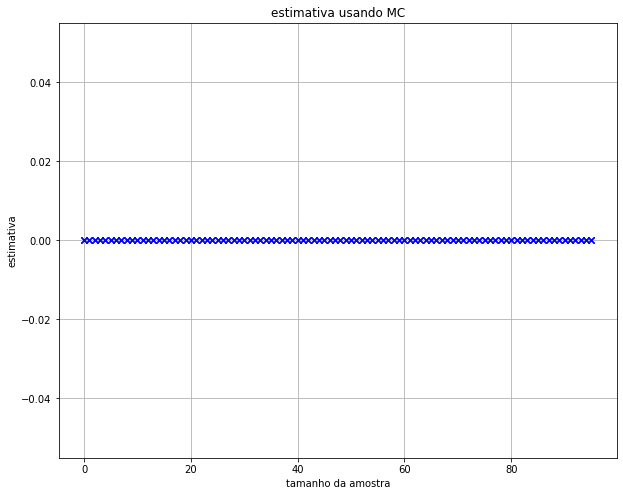

In [32]:
plot_experiment2(estimates)